<a href="https://colab.research.google.com/github/UmeshGayashan/PNEUMONIA-DETECTION-SYSTEM/blob/main/PNEUMONIA_DETECTION_SYSTEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
drive_data_path = '/content/drive/MyDrive/colab_pneumonia_data'
os.makedirs(drive_data_path, exist_ok=True)

In [10]:
# Move kaggle.json credentials if needed
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset to local Colab storage
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

# Unzip into Google Drive
!unzip /content/chest-xray-pneumonia.zip -d "$drive_data_path"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/drive/MyDrive/colab_pneumonia_data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /c

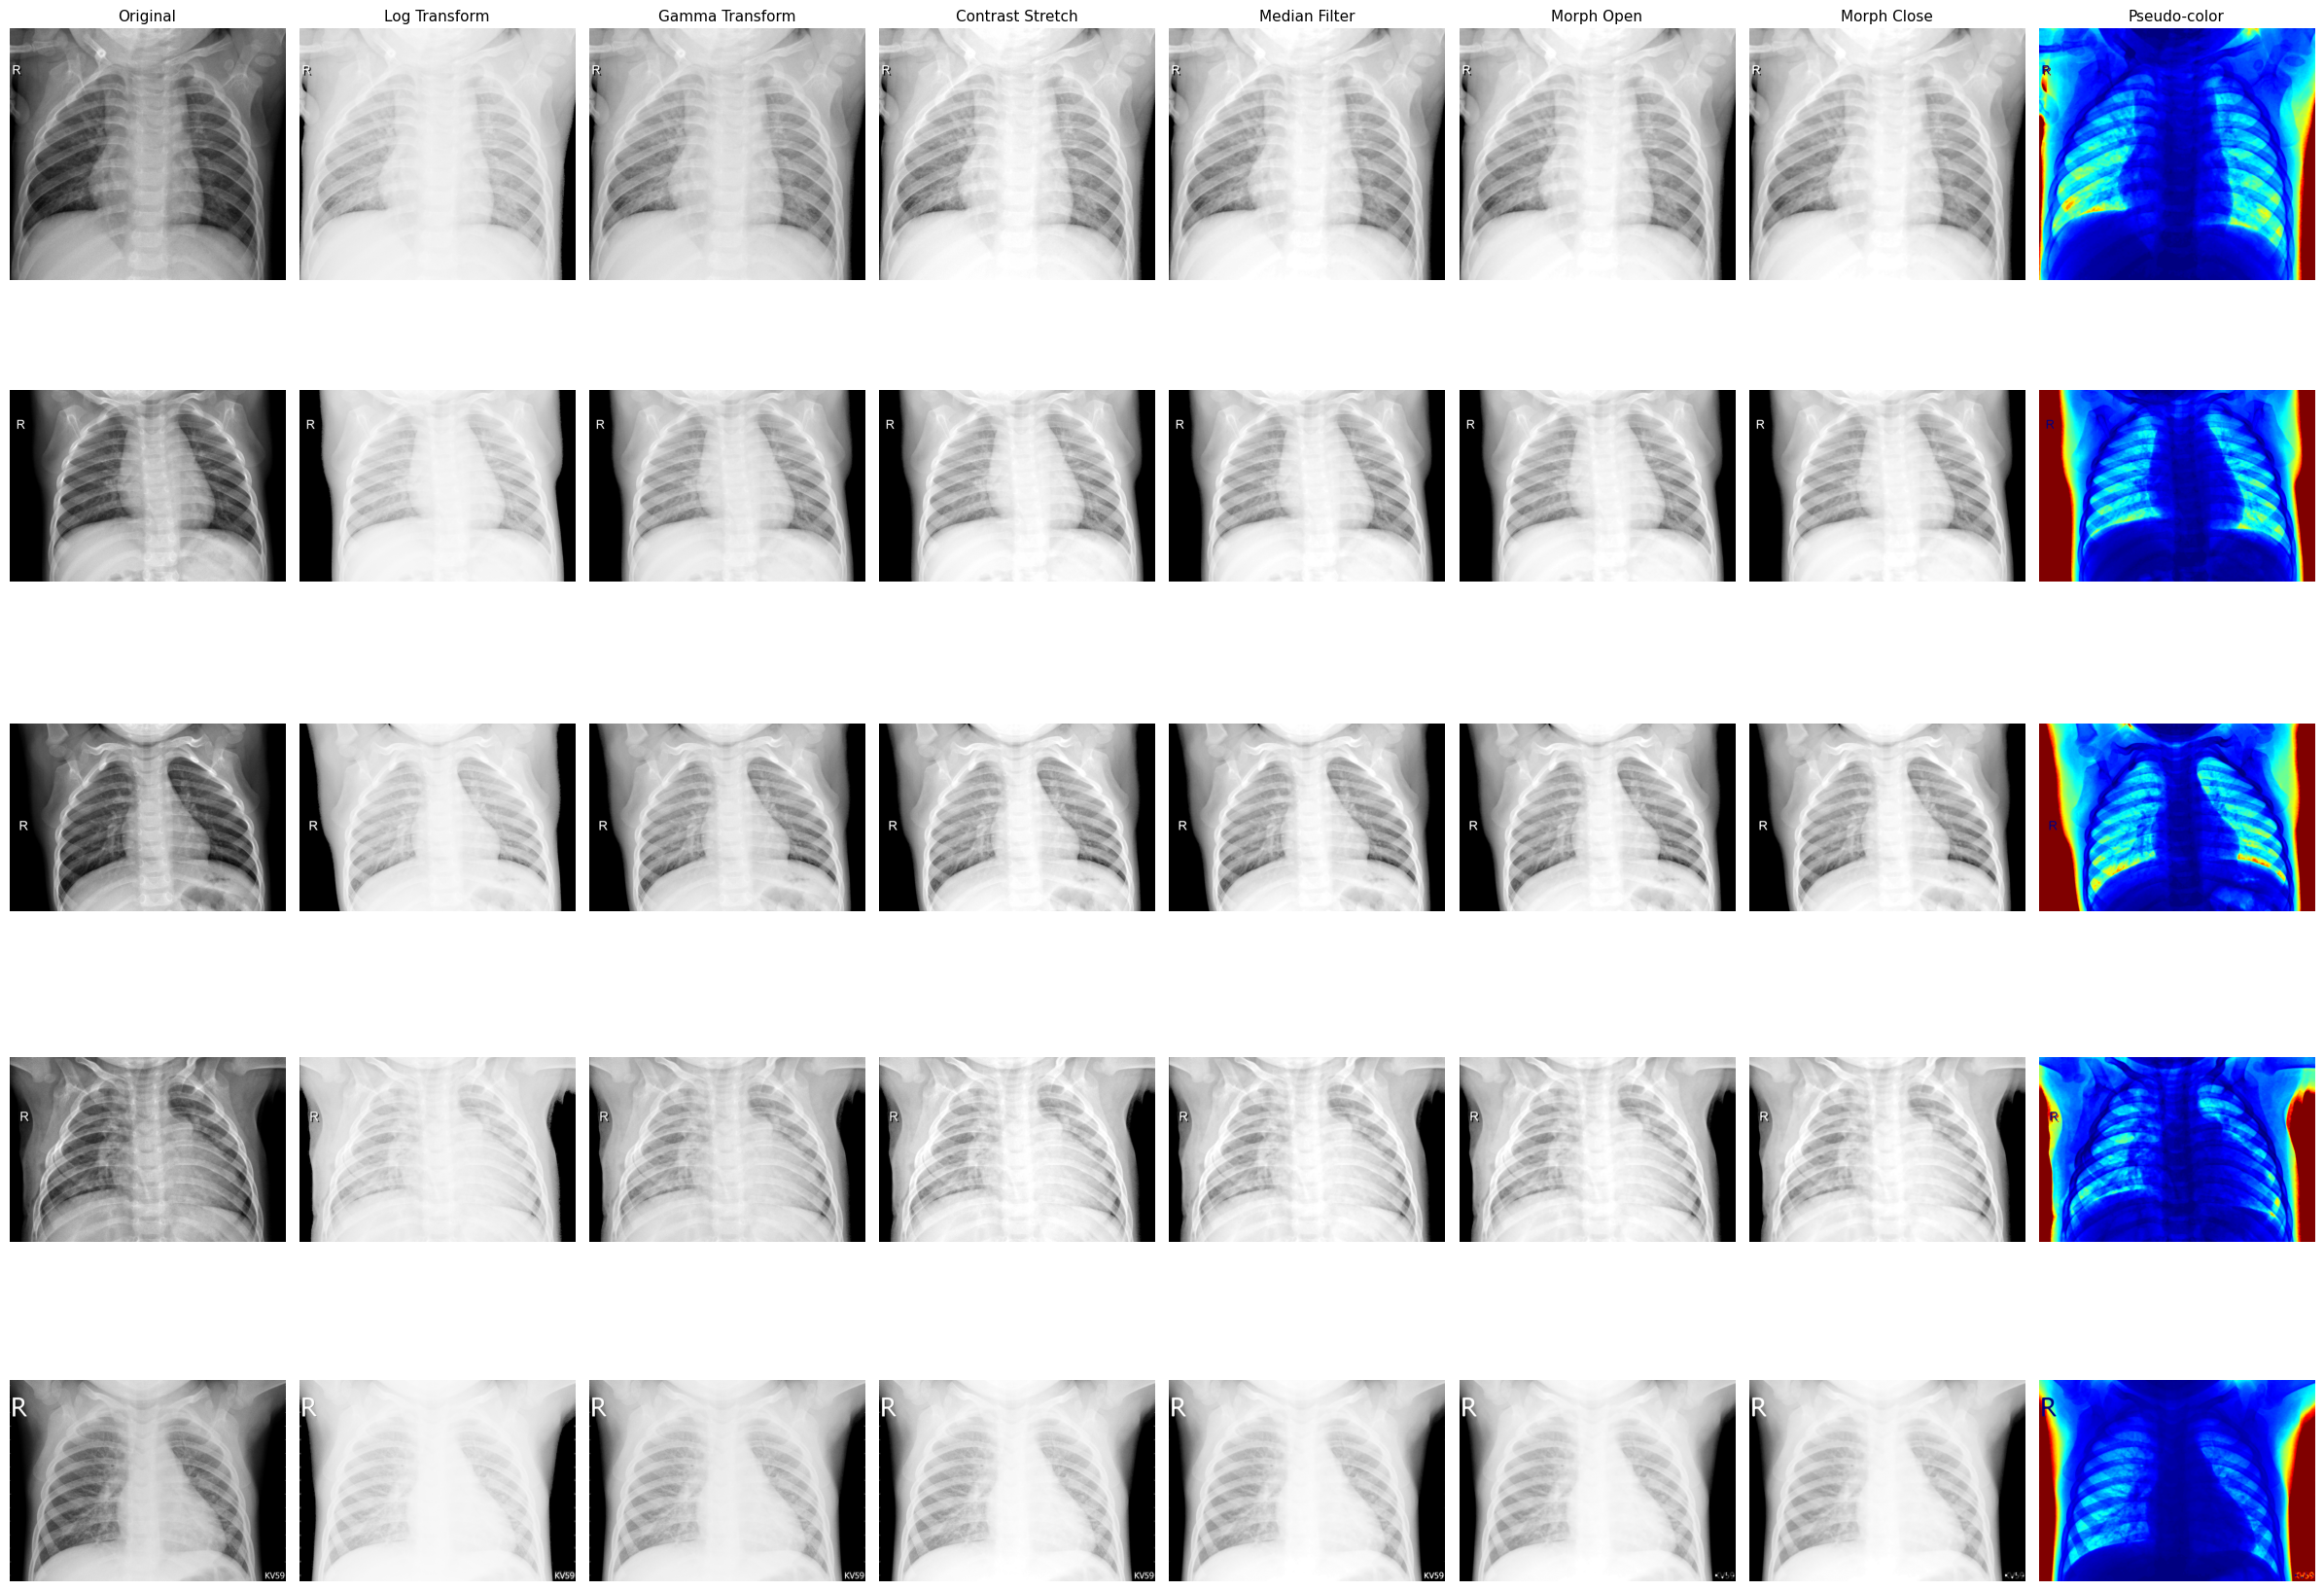

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

# Image processing step functions
def log_transform(img):
    c = 255 / np.log1p(np.max(img))
    return (c * np.log1p(img)).astype(np.uint8)

def gamma_transform(img, gamma=2.0):
    norm_img = img / 255.0
    img_gamma = (255 * norm_img ** gamma)
    return np.uint8(np.clip(img_gamma, 0, 255))

def contrast_stretch(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = np.clip((img - p2) * 255 / (p98 - p2), 0, 255)
    return img_rescale.astype(np.uint8)

def median_filter(img):
    return cv2.medianBlur(img, 5)

def morph_open(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

def morph_close(img):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

def pseudo_color(img):
    return cv2.applyColorMap(img, cv2.COLORMAP_JET)

# You may change this to five normal, five pneumonia, or a mix of both
normal_folder = f"{drive_data_path}/chest_xray/train/NORMAL"
pneumonia_folder = f"{drive_data_path}/chest_xray/train/PNEUMONIA"
image_paths = glob(normal_folder + "/*.jpeg")[:3] + glob(pneumonia_folder + "/*.jpeg")[:2]

step_names = [
    "Original", "Log Transform", "Gamma Transform", "Contrast Stretch",
    "Median Filter", "Morph Open", "Morph Close", "Pseudo-color"
]

plt.figure(figsize=(24,18))

for idx, img_path in enumerate(image_paths):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    imgs = [img]
    imgs.append(log_transform(img))
    imgs.append(gamma_transform(imgs[-1], gamma=2.0))
    imgs.append(contrast_stretch(imgs[-1]))
    imgs.append(median_filter(imgs[-1]))
    imgs.append(morph_open(imgs[-1]))
    imgs.append(morph_close(imgs[-1]))
    imgs.append(pseudo_color(imgs[-1]))

    for j, im in enumerate(imgs):
        plt.subplot(len(image_paths), len(imgs), idx * len(imgs) + j + 1)
        plt.imshow(im if j==7 else im, cmap=None if j==7 else 'gray')
        # Display step names only on top row
        if idx == 0:
            plt.title(step_names[j], fontsize=11)
        plt.axis('off')

plt.tight_layout()
plt.show()
